# Мусін Данило КМ-81 Курсова робота
## Метод Фіакко Маккорміка
### Постановка завдання
Мінімізувати функцію Розенброка методом Фіакко Маккорміка при обмеженні
\begin{equation}
y/3 + x/1.5 > 1 \mbox{ - обмеження}
\end{equation}
\begin{equation}
x_0 = (0.8, 2.5) \mbox{ - початкова точка}
\end{equation}

In [706]:
import math
from functools import partial
from itertools import takewhile

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, animation
from matplotlib.ticker import LinearLocator

In [707]:
# Константи необхідні для алгоритма
phi = (1 + math.sqrt(5)) / 2
epsilon = 0.0001
diff_precision = 0.0000001

def penalty(x, y):
    if y/3 + x/1.5 < 1:
        return np.inf
    else:
        return 0


@np.vectorize
def target_f(x, y):
    a = 1. - x
    b = y - x*x
    return a*a + b*b*100.

@np.vectorize
def target_f_penalty(x, y):
    a = 1. - x
    b = y - x*x
    return a*a + b*b*100. + penalty(x, y)

# @np.vectorize
# def target_f(x, y):
#     return x * x + y * y
# Цільова функция в векторній формі(можна застосовувати до одразу до массивів)

In [708]:
# Константи необхідні для побудови графіка

x_range = (-2, 2)
y_range = (-1, 3)

# x_range = (0.5, 1.8)
# y_range = (1.5, 3)
# Границі графіка по x та y

x_linspace = np.linspace(*x_range, 101)
y_linspace = np.linspace(*y_range, 101)
mgrid_x, mgrid_y = np.meshgrid(x_linspace, y_linspace)
X = mgrid_x.T
Y = mgrid_y.T
# Точки на яких обчислюватиметься функція для побудови графіку

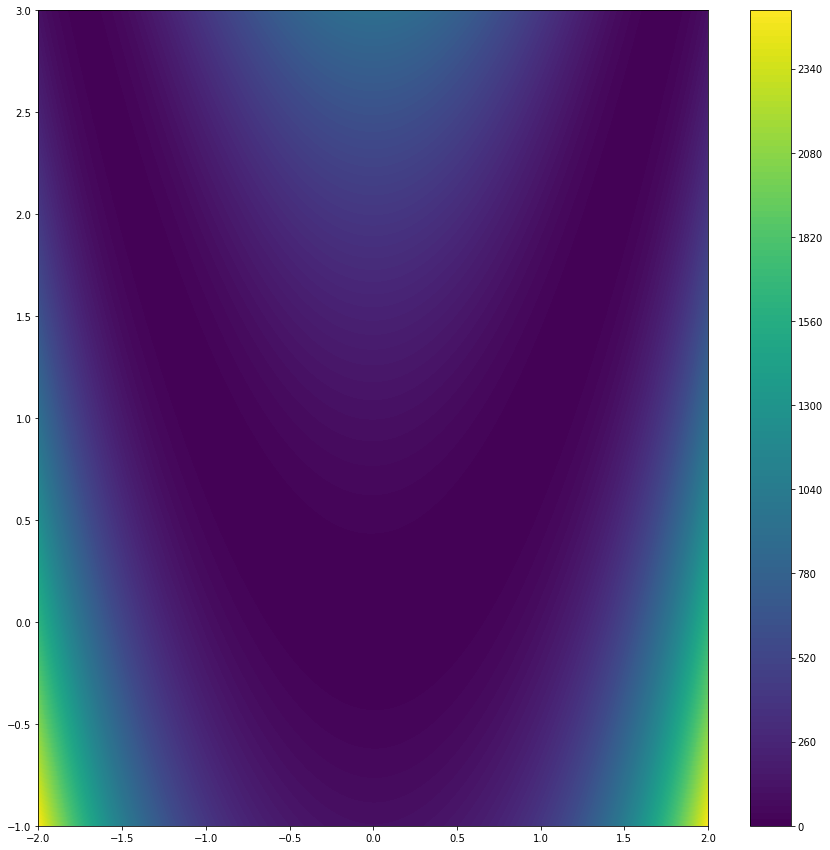

In [709]:
# Побудова двовимірного графіка
Z = target_f(X, Y)
fig, ax = plt.subplots(figsize=(15, 15))

cs = ax.contourf(X, Y, Z, 160)
plt.colorbar(cs)


In [710]:
def optimize(optimizer_func, target_func, *args):
    """Нескінченно застосовує оптимізацію задану в optimizer_func"""
    yield args
    while True:
        args = optimizer_func(target_func, *args)
        yield args

In [711]:
def finite_differences(f, a):
    h = diff_precision

    dx = np.array([h, 0])
    dy = np.array([0, h])
    df_dx = (-f(*(a - dx)) + f(*(a + dx))) / (2 * h)

    df_dy = (-f(*(a - dy)) + f(*(a + dy))) / (2 * h)

    return np.array([df_dx, df_dy])

In [712]:
def svenn(f, point, step):
    if f(*point) < f(*(point + step)):
        return point, -step

    return point + step, step


In [713]:
def golden_ratio(f, a, b):
    x1 = b - (b - a) / phi
    x2 = a + (b - a) / phi

    if f(*x1) > f(*x2):
        return x1, b
    else:
        return a, x2

In [714]:
def grad_desc(f, a, grad, h):
    new_a = a - h * (grad / np.linalg.norm(grad))
    grad = finite_differences(f, new_a)
    return new_a, grad, h

point = [1.44718348 2.09578198]
point = [1.44565535 2.093331  ]
point = [1.31088573 1.70618441]
point = [1.26537331 1.58398168]
point = [1.05193033 1.10826215]
point = [1.03649839 1.0727418 ]
point = [1.00569708 1.00974973]
point = [1.00507322 1.01005475]
point = [1.00507322 1.01005475]
point = [1.00507322 1.01005475]
point = [1.00507322 1.01005475]


<ipython-input-715-c3c422a18018>:46: RuntimeWarning: invalid value encountered in true_divide
  middle_part = (np.outer(H @ yk, yk) @ H) / (H @ yk).dot(yk)
<ipython-input-715-c3c422a18018>:47: RuntimeWarning: invalid value encountered in true_divide
  right_part = (np.outer(sk, sk)) / yk.dot(sk)


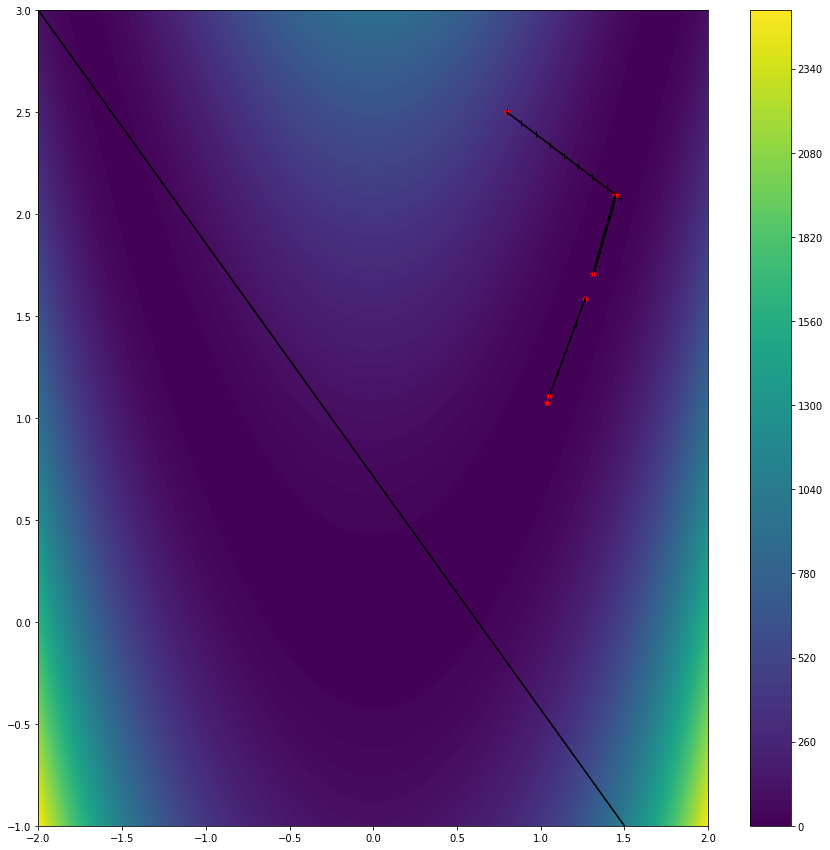

In [715]:
intermediate_points = []

def apply_method(target_f, method, condition, *args):
    method_generator = optimize(method, target_f, *args)
    return [point for point, *_ in takewhile(condition, method_generator)]


def calculate_step(f, a, dir, step_len_svenn):
    step_svenn = step_len_svenn * (dir / np.linalg.norm(dir))


    svenn_condition = lambda point: np.array_equal(step_svenn, point[1])
    optimize_f = partial(apply_method, f)

    svenn_results = optimize_f(svenn, svenn_condition, a, step_svenn)

    intermediate_points.extend(svenn_results)

    interval = svenn_results[-2:]
    if len(interval) == 1:
        interval = [a, a + step_svenn]

    continue_condition = lambda points: abs(np.linalg.norm(points[0] - points[1])) > epsilon

    golden_res = optimize_f(golden_ratio, continue_condition, *interval)

    golden_interval = golden_res[-2:]

    b = (golden_interval[-1] + golden_interval[-2]) / 2

    return np.linalg.norm(a - b)



def dfp(f, a, H, grad, step_svenn):
    dir = -1 * H @ grad

    step = calculate_step(f, a, dir, step_svenn)

    next_a = a + step * (dir / np.linalg.norm(dir))
    grad_new = finite_differences(f, next_a)

    sk = next_a - a
    yk = grad_new - grad

    middle_part = (np.outer(H @ yk, yk) @ H) / (H @ yk).dot(yk)
    right_part = (np.outer(sk, sk)) / yk.dot(sk)

    H = H - middle_part + right_part

    return next_a, H, grad_new, step

start_point = np.array([0.8, 2.5])
grad = finite_differences(target_f, start_point)
step = 0.1
ax.plot([-2, 1.5], [3, -1], color='black')
args = start_point, np.eye(2), grad, step
ax.plot(*args[0], marker='*', color='red')
points = [start_point]
for i in range(11):
    args = dfp(target_f_penalty, *args)
    points.append(args[0])

    print(f'point = {args[0]}')
    # print(f'grad = {args[2]}')
    if len(points) > 3:
        a, b, c = points[-3:]
        len1 = np.linalg.norm(a - b)
        len2 = np.linalg.norm(b - c)
        if len1 < step and len2 < step:
            args = points[-1], np.eye(2), finite_differences(target_f, points[-1]), step
            continue

    ax.plot(*zip(*intermediate_points), marker='|', color='black')
    intermediate_points = []
    ax.plot(*args[0], marker='*', color='red')




fig

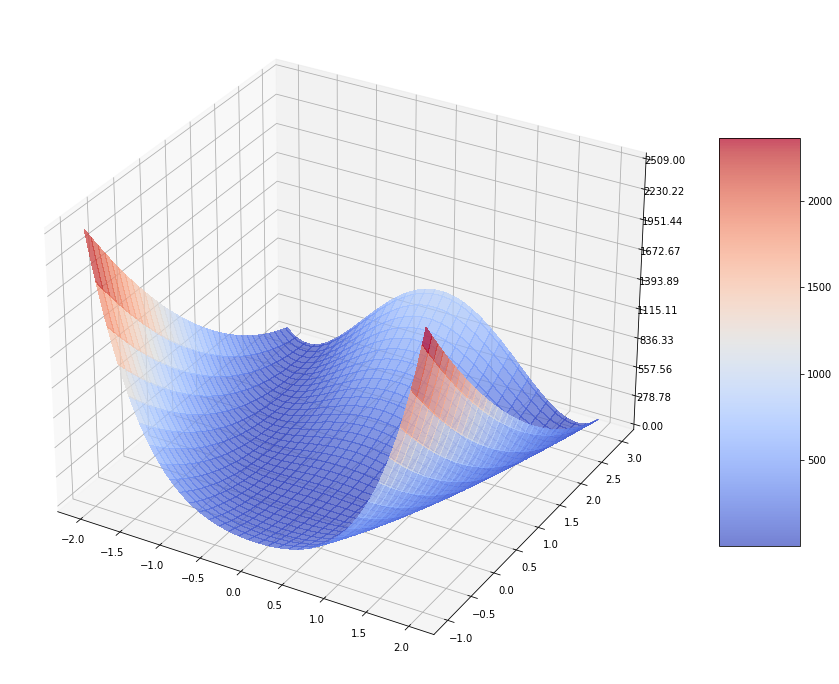

In [716]:
fig2, ax2 = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15, 15))

surf = ax2.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.7, zorder=1)

ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter('{x:.02f}')

fig2.colorbar(surf, shrink=0.5, aspect=5)

plt.show()